In [1]:
#Check para ver si lee mi key

import os
from dotenv import load_dotenv
import requests
import pandas as pd
from io import StringIO
import time

# 1) Cargar el archivo .env
load_dotenv()

# 2) Leer la variable del entorno
API_KEY = os.getenv("AEMET_API_KEY")

# 3) Comprobar que se ha cargado
if API_KEY is None:
    print("No se ha encontrado AEMET_API_KEY. Revisa tu archivo .env")
else:
    print("✅ API key cargada correctamente. Longitud:", len(API_KEY))
    # Opcional: mostrar solo los primeros caracteres para comprobar
    print("Inicio de la key:", API_KEY[:10], "... (oculto)")



✅ API key cargada correctamente. Longitud: 292
Inicio de la key: eyJhbGciOi ... (oculto)


In [2]:
# Estación de Peñafiel (código que ves en la web: 2166Y)
STATION_ID = "2166Y"

# Endpoint /api/ de climatologías mensuales/anuales:
BASE_URL = (
    "https://opendata.aemet.es/opendata/api/"
    "valores/climatologicos/mensualesanuales/datos/"
    "anioini/{year}/aniofin/{year}/estacion/{station}"
)

print("✅ Configuración lista para estación", STATION_ID)


✅ Configuración lista para estación 2166Y


In [3]:
# evitar errores de tiempos de espera

def get_with_retry(url, *, headers=None, params=None, max_retries=5, base_wait=5, label=""):
    """
    Hace una petición GET con reintentos si recibe 429 Too Many Requests.
    - max_retries: nº máximo de intentos.
    - base_wait: segundos base de espera (se multiplica por el nº de intento).
    """
    for attempt in range(1, max_retries + 1):
        try:
            resp = requests.get(url, headers=headers, params=params, timeout=30)
        except Exception as e:
            print(f"[{label}] ❌ Error en intento {attempt}: {e}")
            # si es un error de conexión raro, esperamos un poco y reintentamos
            time.sleep(base_wait * attempt)
            continue

        # Si es 429 Too Many Requests → esperamos y reintentamos
        if resp.status_code == 429:
            wait = base_wait * attempt
            print(f"[{label}] ⚠️ 429 Too Many Requests. Esperando {wait} segundos antes de reintentar...")
            time.sleep(wait)
            continue

        # Para cualquier otro código, si es error >400 lanza excepción:
        try:
            resp.raise_for_status()
            return resp  # éxito
        except requests.exceptions.HTTPError as e:
            print(f"[{label}] ❌ HTTPError (código {resp.status_code}): {e}")
            return None

    print(f"[{label}] ❌ Se alcanzó el nº máximo de reintentos ({max_retries})")
    return None


In [4]:
# Crea función para descargar datos ajustado con control de errores

def get_aemet_year(year):
    """
    Descarga climatologías mensuales/anuales de AEMET para un año y la estación 2166Y.
    Usa la API con reintentos automáticos si recibe 429 Too Many Requests.
    """

    # 1. Construir la URL del endpoint API
    url_api = BASE_URL.format(year=year, station=STATION_ID)

    # 2. Llamar al endpoint /api/... con tu key (con reintentos)
    headers = {"api_key": API_KEY}
    resp = get_with_retry(
        url_api,
        headers=headers,
        params=None,
        max_retries=5,
        base_wait=5,  # puedes bajar o subir esto
        label=f"API {year}"
    )

    if resp is None:
        print(f"[{year}] ❌ No se pudo obtener respuesta válida del endpoint API.")
        return pd.DataFrame()

    info = resp.json()
    estado = info.get("estado")
    desc = info.get("descripcion")

    if estado != 200:
        print(f"[{year}] ❌ Error de API: estado={estado}, descripcion={desc}")
        return pd.DataFrame()

    data_url = info["datos"]  # URL sh/... fresca

    # 3. Descargar los datos desde 'datos' (también con reintentos)
    r_data = get_with_retry(
        data_url,
        headers=None,
        params=None,
        max_retries=5,
        base_wait=5,
        label=f"DATOS {year}"
    )

    if r_data is None:
        print(f"[{year}] ❌ No se pudo descargar la URL de datos.")
        return pd.DataFrame()

    # 4. Intentar primero JSON (detecta 'datos expirados' o datos en JSON)
    try:
        data_json = r_data.json()

        # Caso dict con estado=404 → datos expirados
        if isinstance(data_json, dict) and data_json.get("estado") == 404:
            print(f"[{year}] ⚠️ 'datos expirados' en la URL de datos. Prueba en otro momento.")
            return pd.DataFrame()

        # Caso lista de dicts → datos en JSON
        if isinstance(data_json, list):
            df = pd.DataFrame(data_json)
            df["year"] = year
            print(f"[{year}] ✅ OK JSON con {len(df)} filas")
            return df

    except ValueError:
        # No era JSON → intentamos CSV
        pass

    # 5. Intentar CSV
    try:
        csv_buf = StringIO(r_data.text)
        df = pd.read_csv(csv_buf, sep=";")
        df["year"] = year
        print(f"[{year}] ✅ OK CSV con {len(df)} filas")
        return df
    except Exception as e:
        print(f"[{year}] ❌ Error leyendo CSV: {e}")
        return pd.DataFrame()


In [5]:
# Creamos bucle
# De 2003 a 2024 inclusive
years = list(range(2003, 2025))
dfs = []

for y in years:
    df_y = get_aemet_year(y)
    if not df_y.empty:
        dfs.append(df_y)
    else:
        print(f"[{y}] ⚠️ Sin datos válidos, no se añade al total.")

    # Pausa pequeña entre años para no saturar la API
    time.sleep(5)

if dfs:
    df_aemet = pd.concat(dfs, ignore_index=True, sort=False)
    print(f"\n✅ Concatenación completa: {len(df_aemet)} filas en total.")
else:
    df_aemet = pd.DataFrame()
    print("❌ No se han obtenido datos para ningún año.")

df_aemet.head()



[2003] ✅ OK JSON con 13 filas
[2004] ✅ OK JSON con 13 filas
[2005] ✅ OK JSON con 13 filas
[2006] ✅ OK JSON con 13 filas
[2007] ✅ OK JSON con 13 filas
[2008] ✅ OK JSON con 13 filas
[2009] ✅ OK JSON con 13 filas
[2010] ✅ OK JSON con 13 filas
[2011] ✅ OK JSON con 13 filas
[2012] ✅ OK JSON con 13 filas
[2013] ✅ OK JSON con 13 filas
[2014] ✅ OK JSON con 13 filas
[2015] ✅ OK JSON con 13 filas
[2016] ✅ OK JSON con 13 filas
[2017] ✅ OK JSON con 13 filas
[2018] ✅ OK JSON con 13 filas
[2019] ✅ OK JSON con 13 filas
[2020] ✅ OK JSON con 13 filas
[API 2021] ⚠️ 429 Too Many Requests. Esperando 5 segundos antes de reintentar...
[2021] ✅ OK JSON con 13 filas
[2022] ✅ OK JSON con 13 filas
[2023] ✅ OK JSON con 13 filas
[2024] ✅ OK JSON con 13 filas

✅ Concatenación completa: 286 filas en total.


,indicativo,p_max,np_100,np_001,np_300,p_mes,np_010,fecha,tm_min,ta_max,...,nt_00,ti_max,tm_mes,tm_max,year,e,hr,n_cub,n_des,n_nub
0,2166Y,22.8(30),5,19,0,121.2,15,2003-10,NaN,NaN,...,NaN,NaN,NaN,NaN,2003,NaN,NaN,NaN,NaN,NaN
1,2166Y,11.6(23),1,15,0,48.8,8,2003-11,NaN,NaN,...,NaN,NaN,NaN,NaN,2003,NaN,NaN,NaN,NaN,NaN
2,2166Y,5.6(29),0,15,0,26.2,5,2003-12,0.4,16.2(21),...,16,3.0,4.7,8.9,2003,NaN,NaN,NaN,NaN,NaN
3,2166Y,NaN,NaN,NaN,NaN,NaN,NaN,2003-13,NaN,NaN,...,NaN,NaN,NaN,NaN,2003,NaN,NaN,NaN,NaN,NaN
4,2166Y,NaN,NaN,NaN,NaN,NaN,NaN,2003-1,NaN,NaN,...,NaN,NaN,NaN,NaN,2003,NaN,NaN,NaN,NaN,NaN


In [6]:
# Exportar a CSV
df_aemet.to_csv("aemet_vino_raw.csv", index=False)

In [7]:
#Mostrar todas las columnas del dataframe
pd.set_option('display.max_columns', None)
print(df_aemet.columns)

Index(['indicativo', 'p_max', 'np_100', 'np_001', 'np_300', 'p_mes', 'np_010',
       'fecha', 'tm_min', 'ta_max', 'ts_min', 'nt_30', 'ta_min', 'nt_00',
       'ti_max', 'tm_mes', 'tm_max', 'year', 'e', 'hr', 'n_cub', 'n_des',
       'n_nub'],
      dtype='object')


In [8]:
# copy para no perder columnas originales
df_aemet_clean = df_aemet.copy()


In [9]:
# Data cleaning: nos quedamos con las columnas que nos interesan y las renombramos
# columnas de interés: indicativo, fecha, p_mes, nt_30, nt_00, tm_mes, year, hr
df_aemet_clean = df_aemet.rename(columns={"indicativo": "estacion", "fecha": "fecha_mes", "p_mes": "precipitacion_total_mensual", 
                          "nt_30": "num_dias_temp_mayor30", "nt_00": "num_dias_temp_menor0", 
                          "tm_mes": "temp_media_mes", "year": "año", "hr": "humedad_relativa"})
df_aemet_clean.head()


,estacion,p_max,np_100,np_001,np_300,precipitacion_total_mensual,np_010,fecha_mes,tm_min,ta_max,ts_min,num_dias_temp_mayor30,ta_min,num_dias_temp_menor0,ti_max,temp_media_mes,tm_max,año,e,humedad_relativa,n_cub,n_des,n_nub
0,2166Y,22.8(30),5,19,0,121.2,15,2003-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,NaN,NaN,NaN,NaN,NaN
1,2166Y,11.6(23),1,15,0,48.8,8,2003-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,NaN,NaN,NaN,NaN,NaN
2,2166Y,5.6(29),0,15,0,26.2,5,2003-12,0.4,16.2(21),6.0,0,-3.7(17),16,3.0,4.7,8.9,2003,NaN,NaN,NaN,NaN,NaN
3,2166Y,NaN,NaN,NaN,NaN,NaN,NaN,2003-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,NaN,NaN,NaN,NaN,NaN
4,2166Y,NaN,NaN,NaN,NaN,NaN,NaN,2003-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,NaN,NaN,NaN,NaN,NaN


In [10]:
#check datos columnas
df_aemet_clean.dtypes

estacion                       object
p_max                          object
np_100                         object
np_001                         object
np_300                         object
precipitacion_total_mensual    object
np_010                         object
fecha_mes                      object
tm_min                         object
ta_max                         object
ts_min                         object
num_dias_temp_mayor30          object
ta_min                         object
num_dias_temp_menor0           object
ti_max                         object
temp_media_mes                 object
tm_max                         object
año                             int64
e                              object
humedad_relativa               object
n_cub                          object
n_des                          object
n_nub                          object
dtype: object

In [11]:
# Cambiar todo el dataframe a float excepto las columnas de fecha_mes, año y estacion (excepto tambien las que tienen paréntesis)
cols_to_float = [col for col in df_aemet_clean.columns if col not in ['fecha_mes', 'año', 'estacion', 'p_max', 'ta_max', 'ta_min']]
df_aemet_clean[cols_to_float] = df_aemet_clean[cols_to_float].astype(float)
df_aemet_clean.dtypes



estacion                        object
p_max                           object
np_100                         float64
np_001                         float64
np_300                         float64
precipitacion_total_mensual    float64
np_010                         float64
fecha_mes                       object
tm_min                         float64
ta_max                          object
ts_min                         float64
num_dias_temp_mayor30          float64
ta_min                          object
num_dias_temp_menor0           float64
ti_max                         float64
temp_media_mes                 float64
tm_max                         float64
año                              int64
e                              float64
humedad_relativa               float64
n_cub                          float64
n_des                          float64
n_nub                          float64
dtype: object

In [12]:
df_aemet_clean.columns.tolist()

['estacion',
 'p_max',
 'np_100',
 'np_001',
 'np_300',
 'precipitacion_total_mensual',
 'np_010',
 'fecha_mes',
 'tm_min',
 'ta_max',
 'ts_min',
 'num_dias_temp_mayor30',
 'ta_min',
 'num_dias_temp_menor0',
 'ti_max',
 'temp_media_mes',
 'tm_max',
 'año',
 'e',
 'humedad_relativa',
 'n_cub',
 'n_des',
 'n_nub']

In [13]:
# Crear una nueva columna para calcular la humedad de una forma manual -> tm_min/tm_max * 100 - asegurándonos de que ambas columnas son numéricas 
df_aemet_clean["humedad_relativa_manual"] = (
    df_aemet_clean["tm_min"] / df_aemet_clean["tm_max"] * 100
)

df_aemet_clean.head(20)


,estacion,p_max,np_100,np_001,np_300,precipitacion_total_mensual,np_010,fecha_mes,tm_min,ta_max,ts_min,num_dias_temp_mayor30,ta_min,num_dias_temp_menor0,ti_max,temp_media_mes,tm_max,año,e,humedad_relativa,n_cub,n_des,n_nub,humedad_relativa_manual
0,2166Y,22.8(30),5.0,19.0,0.0,121.2,15.0,2003-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,NaN,NaN,NaN,NaN,NaN,NaN
1,2166Y,11.6(23),1.0,15.0,0.0,48.8,8.0,2003-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,NaN,NaN,NaN,NaN,NaN,NaN
2,2166Y,5.6(29),0.0,15.0,0.0,26.2,5.0,2003-12,0.4,16.2(21),6.0,0.0,-3.7(17),16.0,3.0,4.7,8.9,2003,NaN,NaN,NaN,NaN,NaN,4.494382
3,2166Y,NaN,NaN,NaN,NaN,NaN,NaN,2003-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,NaN,NaN,NaN,NaN,NaN,NaN
4,2166Y,NaN,NaN,NaN,NaN,NaN,NaN,2003-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,NaN,NaN,NaN,NaN,NaN,NaN
5,2166Y,10.4(18),2.0,13.0,0.0,42.6,8.0,2003-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,NaN,NaN,NaN,NaN,NaN,NaN
6,2166Y,14.8(22),1.0,10.0,0.0,29.0,5.0,2003-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,NaN,NaN,NaN,NaN,NaN,NaN
7,2166Y,15.0(19),1.0,10.0,0.0,38.2,8.0,2003-4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,NaN,NaN,NaN,NaN,NaN,NaN
8,2166Y,6.8(31),0.0,7.0,0.0,26.2,6.0,2003-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,NaN,NaN,NaN,NaN,NaN,NaN
9,2166Y,6.4(12),0.0,9.0,0.0,19.4,8.0,2003-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df_aemet_clean.columns.tolist()

['estacion',
 'p_max',
 'np_100',
 'np_001',
 'np_300',
 'precipitacion_total_mensual',
 'np_010',
 'fecha_mes',
 'tm_min',
 'ta_max',
 'ts_min',
 'num_dias_temp_mayor30',
 'ta_min',
 'num_dias_temp_menor0',
 'ti_max',
 'temp_media_mes',
 'tm_max',
 'año',
 'e',
 'humedad_relativa',
 'n_cub',
 'n_des',
 'n_nub',
 'humedad_relativa_manual']

In [15]:
#Eliminar columnas innecesarias, por ejemplo np_100
df_aemet_clean.drop(columns=['np_100', 'np_001', 'np_300', 'np_010', 'tm_min', 'ta_max', 'ts_min', 'ta_min', 'ti_max', 'tm_max', 'e', 'n_cub', 'n_des', 'n_nub', 'p_max'], inplace=True)
df_aemet_clean.head()

,estacion,precipitacion_total_mensual,fecha_mes,num_dias_temp_mayor30,num_dias_temp_menor0,temp_media_mes,año,humedad_relativa,humedad_relativa_manual
0,2166Y,121.2,2003-10,NaN,NaN,NaN,2003,NaN,NaN
1,2166Y,48.8,2003-11,NaN,NaN,NaN,2003,NaN,NaN
2,2166Y,26.2,2003-12,0.0,16.0,4.7,2003,NaN,4.494382
3,2166Y,NaN,2003-13,NaN,NaN,NaN,2003,NaN,NaN
4,2166Y,NaN,2003-1,NaN,NaN,NaN,2003,NaN,NaN


In [16]:
#Data cleanining de la columna de "fecha_mes" para tener mes y año (no días),
#por ejemplo tengo el formato "2003-1" quiero que sea 2003 en una columna y en otra columna lo que está después del "-", es decir, 1
# Separar en dos columnas: año y mes
df_aemet_clean[["año", "mes"]] = (
    df_aemet_clean["fecha_mes"]
        .astype(str)                # por si viene como número
        .str.split("-", expand=True)
        .astype(int)                # si quieres que sean enteros
)

df_aemet_clean.head()



,estacion,precipitacion_total_mensual,fecha_mes,num_dias_temp_mayor30,num_dias_temp_menor0,temp_media_mes,año,humedad_relativa,humedad_relativa_manual,mes
0,2166Y,121.2,2003-10,NaN,NaN,NaN,2003,NaN,NaN,10
1,2166Y,48.8,2003-11,NaN,NaN,NaN,2003,NaN,NaN,11
2,2166Y,26.2,2003-12,0.0,16.0,4.7,2003,NaN,4.494382,12
3,2166Y,NaN,2003-13,NaN,NaN,NaN,2003,NaN,NaN,13
4,2166Y,NaN,2003-1,NaN,NaN,NaN,2003,NaN,NaN,1


In [17]:
#Ordenar ascendentemente por año y mes:

df_aemet_clean = (
    df_aemet_clean
        .sort_values(["año", "mes"], ascending=[True, True])
        .reset_index(drop=True)
)

df_aemet_clean.head()

,estacion,precipitacion_total_mensual,fecha_mes,num_dias_temp_mayor30,num_dias_temp_menor0,temp_media_mes,año,humedad_relativa,humedad_relativa_manual,mes
0,2166Y,NaN,2003-1,NaN,NaN,NaN,2003,NaN,NaN,1
1,2166Y,42.6,2003-2,NaN,NaN,NaN,2003,NaN,NaN,2
2,2166Y,29.0,2003-3,NaN,NaN,NaN,2003,NaN,NaN,3
3,2166Y,38.2,2003-4,NaN,NaN,NaN,2003,NaN,NaN,4
4,2166Y,26.2,2003-5,NaN,NaN,NaN,2003,NaN,NaN,5


In [18]:
# Exportar a excel - check 2
df_aemet_clean.to_excel("aemet_vino_clean.xlsx", index=False)


In [19]:
# Nos quedamos con los meses del 1 al 12, ambos incluidos y eliminamos el resto y también eliminamos 2003 porque no tiene datos completos
df_aemet_clean = df_aemet_clean[
    (df_aemet_clean["mes"] >= 1 ) &  (df_aemet_clean["mes"] <= 12) &
    (df_aemet_clean["año"] != 2003)
]
df_aemet_clean.head(20)


,estacion,precipitacion_total_mensual,fecha_mes,num_dias_temp_mayor30,num_dias_temp_menor0,temp_media_mes,año,humedad_relativa,humedad_relativa_manual,mes
13,2166Y,22.6,2004-1,0.0,14.0,5.8,2004,NaN,16.161616,1
14,2166Y,13.2,2004-2,0.0,19.0,5.8,2004,NaN,-8.730159,2
15,2166Y,0.6,2004-3,0.0,13.0,7.1,2004,NaN,7.518797,3
16,2166Y,0.0,2004-4,0.0,4.0,9.2,2004,NaN,15.822785,4
17,2166Y,0.2,2004-5,0.0,1.0,12.9,2004,NaN,33.160622,5
18,2166Y,0.0,2004-6,12.0,0.0,20.3,2004,NaN,40.138408,6
19,2166Y,0.0,2004-7,18.0,0.0,20.7,2004,NaN,39.393939,7
20,2166Y,NaN,2004-8,NaN,NaN,NaN,2004,NaN,NaN,8
21,2166Y,NaN,2004-9,3.0,0.0,18.1,2004,NaN,33.703704,9
22,2166Y,NaN,2004-10,1.0,1.0,13.4,2004,NaN,36.040609,10


In [20]:
#exportar excel - datos_mensuales_aemet.xlsx", index=False)
df_aemet_clean.to_excel("datos_mensuales_aemet.xlsx", index=False)
df_aemet_clean.head()

,estacion,precipitacion_total_mensual,fecha_mes,num_dias_temp_mayor30,num_dias_temp_menor0,temp_media_mes,año,humedad_relativa,humedad_relativa_manual,mes
13,2166Y,22.6,2004-1,0.0,14.0,5.8,2004,NaN,16.161616,1
14,2166Y,13.2,2004-2,0.0,19.0,5.8,2004,NaN,-8.730159,2
15,2166Y,0.6,2004-3,0.0,13.0,7.1,2004,NaN,7.518797,3
16,2166Y,0.0,2004-4,0.0,4.0,9.2,2004,NaN,15.822785,4
17,2166Y,0.2,2004-5,0.0,1.0,12.9,2004,NaN,33.160622,5


In [26]:
!pip install matplotlib


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
# === AEMET: gráficos por año y mes (solo matplotlib) ===

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Utilidades ----------
def normalize_col(c: str) -> str:
    c2 = c.strip().lower()
    c2 = (c2.replace("á","a").replace("é","e").replace("í","i")
              .replace("ó","o").replace("ú","u").replace("ñ","n"))
    c2 = c2.replace("%","pct").replace("°","").replace("º","")
    c2 = re.sub(r"[^\w]+", "_", c2).strip("_")
    return c2

def prettify_label(c: str) -> str:
    s = c.replace("_"," ").strip().title()
    s = (s.replace("Pct","%")
           .replace("Temp","Temperatura")
           .replace("Precipitacion","Precipitación")
           .replace("Humedad Rel","Humedad Relativa"))
    return s

def build_fecha(df: pd.DataFrame) -> pd.DataFrame:
    # intenta columna de fecha directa
    for cand in ["fecha","date","periodo","fechames","mes_ano","anio_mes","ano_mes"]:
        if cand in df.columns:
            dt = pd.to_datetime(df[cand], errors="coerce", dayfirst=True)
            if dt.notna().any():
                df["fecha"] = dt
                break
    # si no, intenta partir de año/mes
    if "fecha" not in df.columns or df["fecha"].isna().all():
        mcol = next((c for c in ["mes","month","mes_num","n_mes"] if c in df.columns), None)
        ycol = next((c for c in ["año","ano","anio","year"] if c in df.columns), None)
        if mcol and ycol:
            months_map = {
                "enero":1,"febrero":2,"marzo":3,"abril":4,"mayo":5,"junio":6,
                "julio":7,"agosto":8,"septiembre":9,"setiembre":9,"octubre":10,"noviembre":11,"diciembre":12,
                "jan":1,"january":1,"feb":2,"february":2,"mar":3,"march":3,"apr":4,"april":4,"may":5,"jun":6,"june":6,
                "jul":7,"july":7,"aug":8,"august":8,"sep":9,"sept":9,"september":9,"oct":10,"october":10,
                "nov":11,"november":11,"dec":12,"december":12
            }
            mvals = df[mcol].astype(str).str.strip().str.lower().map(months_map)
            mvals = mvals.fillna(pd.to_numeric(df[mcol], errors="coerce"))
            yvals = pd.to_numeric(df[ycol], errors="coerce")
            df["fecha"] = pd.to_datetime({"year": yvals, "month": mvals, "day": 1}, errors="coerce")
    # derivados
    if "fecha" in df.columns:
        df = df.sort_values("fecha").reset_index(drop=True)
        df["año"] = df["fecha"].dt.year
        df["mes"] = df["fecha"].dt.month
    return df

def select_numeric_vars(df: pd.DataFrame) -> list:
    meta = {"fecha","año","ano","anio","mes","id","codigo","code","municipio",
            "estacion","provincia","region","comunidad","lat","lon","latitud","longitud"}
    candidates = []
    for c in df.columns:
        if c in meta: 
            continue
        if pd.api.types.is_numeric_dtype(df[c]):
            candidates.append(c)
        elif any(p in c for p in ["precipitacion","temp","humedad","dias","viento","insolacion","radiacion","nieve"]):
            coerced = pd.to_numeric(df[c], errors="coerce")
            if coerced.notna().sum() >= max(3, int(0.5*len(df))):
                df[c] = coerced
                candidates.append(c)
    return candidates

# ---------- Lectura ----------
# Cambia la ruta a tu fichero local si no usas el que subiste
excel_path = "datos_mensuales_aemet.xlsx"
df = pd.read_excel(excel_path)
df.columns = [normalize_col(c) for c in df.columns]
df = build_fecha(df)

# Sugerencia de variables (ajusta según tus nombres reales):
# Por ejemplo: ["precipitacion_total_mensual_mm","temp_media_mes_c","humedad_rel"]
vars_to_plot = select_numeric_vars(df)  # o define tu lista manualmente

# ---------- Gráficos base ----------
def plot_time_series(df: pd.DataFrame, col: str):
    """Serie temporal mensual."""
    if "fecha" not in df.columns or df["fecha"].isna().all():
        raise ValueError("No hay columna 'fecha' válida para serie temporal.")
    temp = df[["fecha", col]].dropna()
    if temp.empty:
        return
    plt.figure(figsize=(10, 4.5))
    plt.plot(temp["fecha"], temp[col], marker="o")
    plt.title(f"Evolución mensual: {prettify_label(col)}")
    plt.xlabel("Fecha"); plt.ylabel(prettify_label(col))
    plt.grid(True); plt.tight_layout(); plt.show()

def plot_monthly_climatology(df: pd.DataFrame, col: str, agg: str = "mean"):
    """Climatología mensual media/mediana/suma (por mes del año)."""
    if "mes" not in df.columns:
        raise ValueError("Falta columna 'mes'.")
    temp = df[["mes", col]].dropna()
    if temp.empty:
        return
    if agg == "sum":
        clim = temp.groupby("mes")[col].sum().reindex(range(1,13))
        ttl = "Climatología mensual (suma)"
    elif agg == "median":
        clim = temp.groupby("mes")[col].median().reindex(range(1,13))
        ttl = "Climatología mensual (mediana)"
    else:
        clim = temp.groupby("mes")[col].mean().reindex(range(1,13))
        ttl = "Climatología mensual (media)"
    plt.figure(figsize=(10, 4.5))
    plt.bar(clim.index, clim.values)
    plt.xticks(range(1,13), ["E","F","M","A","M","J","J","A","S","O","N","D"])
    plt.title(f"{ttl}: {prettify_label(col)}")
    plt.xlabel("Mes"); plt.ylabel(prettify_label(col))
    plt.grid(True, axis="y"); plt.tight_layout(); plt.show()

def plot_annual_aggregate(df: pd.DataFrame, col: str, agg: str = "mean"):
    """Agregado anual para ver tendencias por año (media/mediana/suma)."""
    if "año" not in df.columns:
        raise ValueError("Falta columna 'año'.")
    temp = df[["año", col]].dropna()
    if temp.empty:
        return
    if agg == "sum":
        ann = temp.groupby("año")[col].sum()
        ttl = "Acumulado anual"
    elif agg == "median":
        ann = temp.groupby("año")[col].median()
        ttl = "Mediana anual"
    else:
        ann = temp.groupby("año")[col].mean()
        ttl = "Media anual"
    plt.figure(figsize=(10, 4.5))
    plt.bar(ann.index.astype(int), ann.values)
    plt.title(f"{ttl}: {prettify_label(col)}")
    plt.xlabel("Año"); plt.ylabel(prettify_label(col))
    plt.grid(True, axis="y"); plt.tight_layout(); plt.show()

def plot_year_month_heatmap(df: pd.DataFrame, col: str, agg: str = "sum"):
    """Heatmap Año x Mes (útil para precipitación: acumulado; para temperatura: media)."""
    if not {"año","mes"}.issubset(df.columns):
        raise ValueError("Faltan columnas 'año' y/o 'mes'.")
    temp = df[["año","mes",col]].dropna()
    if temp.empty:
        return
    if agg == "mean":
        pv = temp.pivot_table(index="año", columns="mes", values=col, aggfunc="mean")
    elif agg == "median":
        pv = temp.pivot_table(index="año", columns="mes", values=col, aggfunc="median")
    else:
        pv = temp.pivot_table(index="año", columns="mes", values=col, aggfunc="sum")
    pv = pv.reindex(columns=range(1,13))
    plt.figure(figsize=(10, 6))
    im = plt.imshow(pv.values, aspect="auto")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(12), ["E","F","M","A","M","J","J","A","S","O","N","D"])
    plt.yticks(range(len(pv.index)), pv.index.astype(int))
    ttl = {"sum":"(suma)", "mean":"(media)", "median":"(mediana)"}[agg] if agg in {"sum","mean","median"} else ""
    plt.title(f"Heatmap Año x Mes: {prettify_label(col)} {ttl}")
    plt.xlabel("Mes"); plt.ylabel("Año")
    plt.tight_layout(); plt.show()

def plot_scatter_with_corr(df: pd.DataFrame, xcol: str, ycol: str):
    """Dispersión con correlación (para insights entre variables, ej. temp vs precip)."""
    temp = df[[xcol, ycol]].dropna()
    if temp.empty:
        return
    plt.figure(figsize=(6.5, 6))
    plt.scatter(temp[xcol], temp[ycol])
    r = np.corrcoef(temp[xcol], temp[ycol])[0,1] if len(temp) >= 3 else np.nan
    title = f"{prettify_label(ycol)} vs {prettify_label(xcol)}"
    if not np.isnan(r):
        title += f" (r={r:.2f})"
    plt.title(title)
    plt.xlabel(prettify_label(xcol)); plt.ylabel(prettify_label(ycol))
    plt.grid(True); plt.tight_layout(); plt.show()



In [32]:
import matplotlib.dates as mdates  # arriba del todo del script

def plot_time_series(df: pd.DataFrame, col: str):
    """Serie temporal mensual."""
    if "fecha" not in df.columns or df["fecha"].isna().all():
        raise ValueError("No hay columna 'fecha' válida para serie temporal.")
    temp = df[["fecha", col]].dropna()
    if temp.empty:
        return
    plt.figure(figsize=(10, 4.5))
    plt.plot(temp["fecha"], temp[col], marker="o")
    plt.title(f"Evolución mensual: {prettify_label(col)}")
    plt.xlabel("Fecha"); plt.ylabel(prettify_label(col))
    plt.grid(True)

    # 👉 Un tick por año en el eje X
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

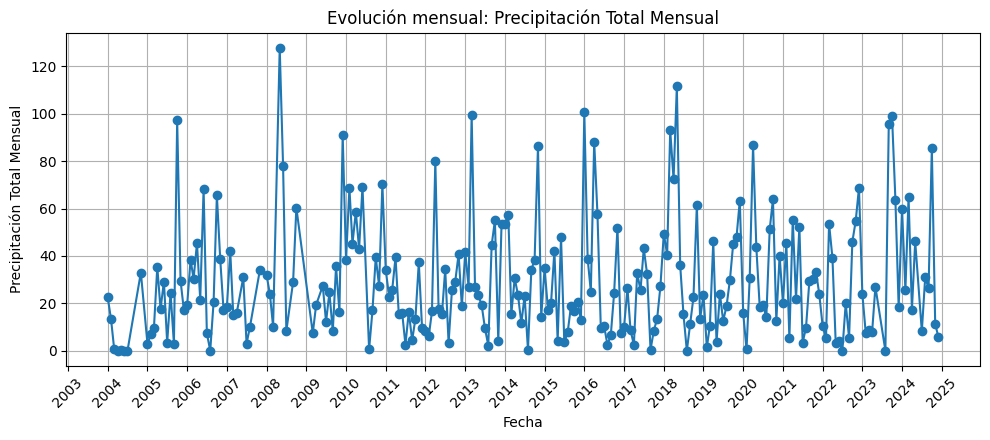

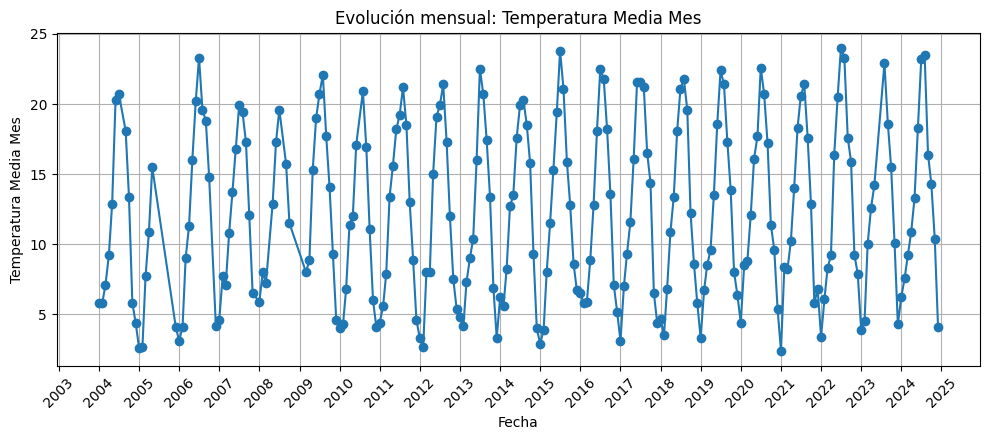

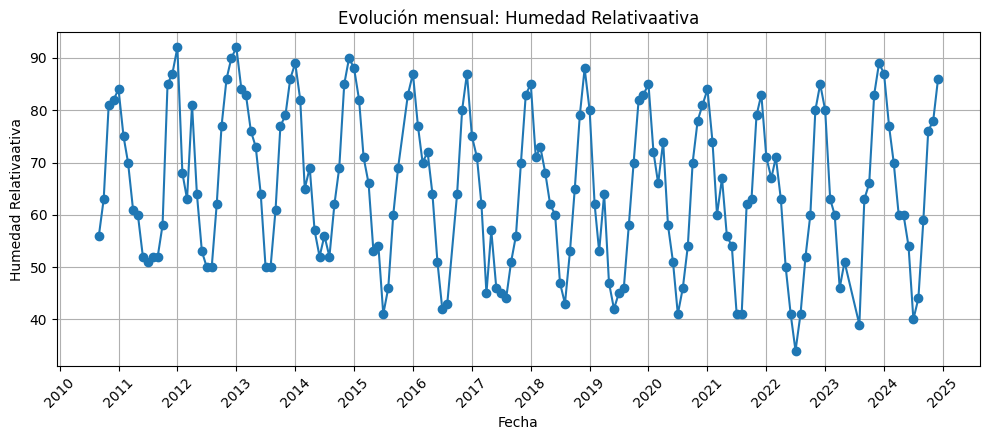

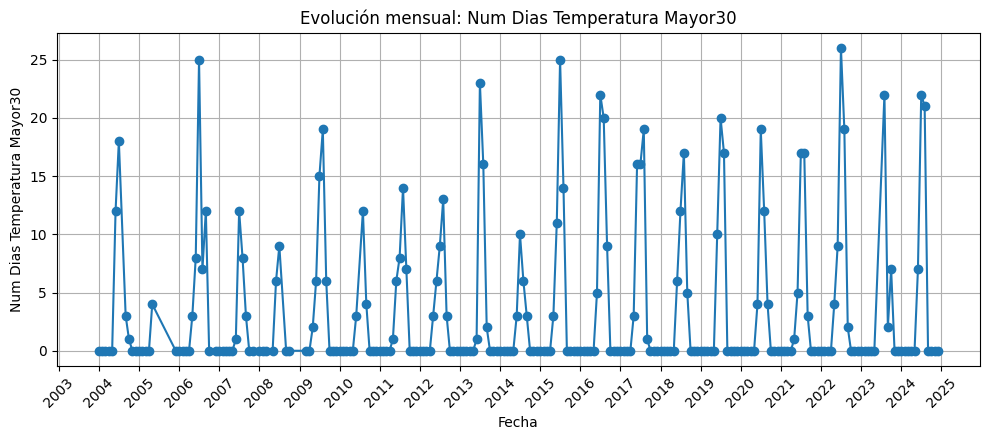

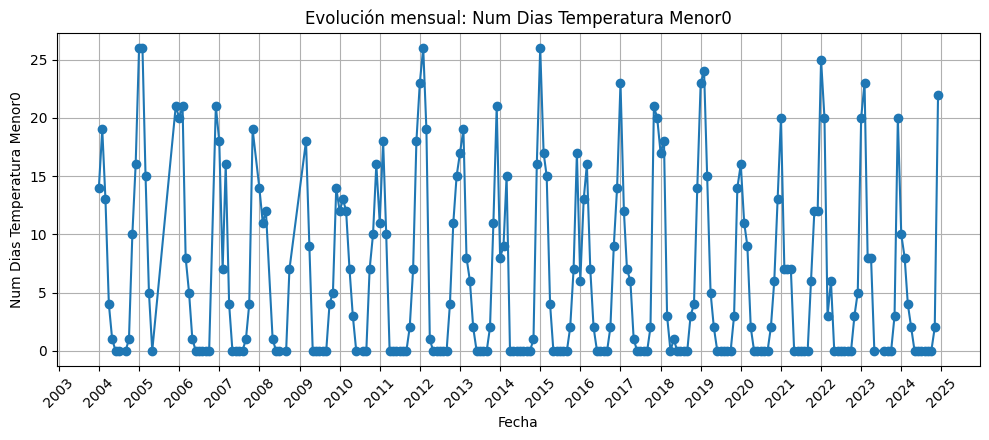

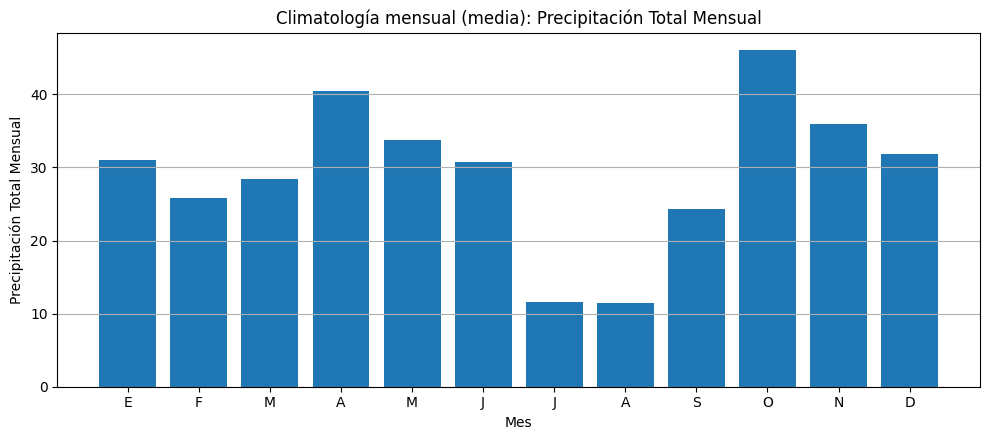

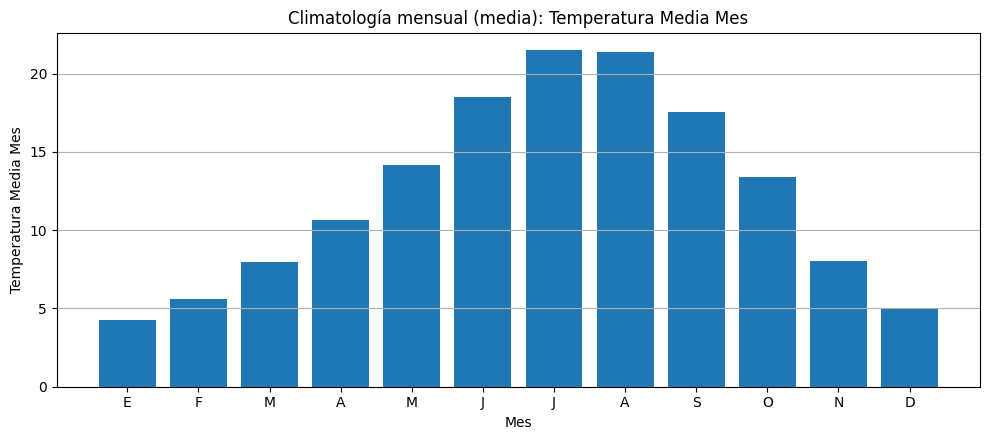

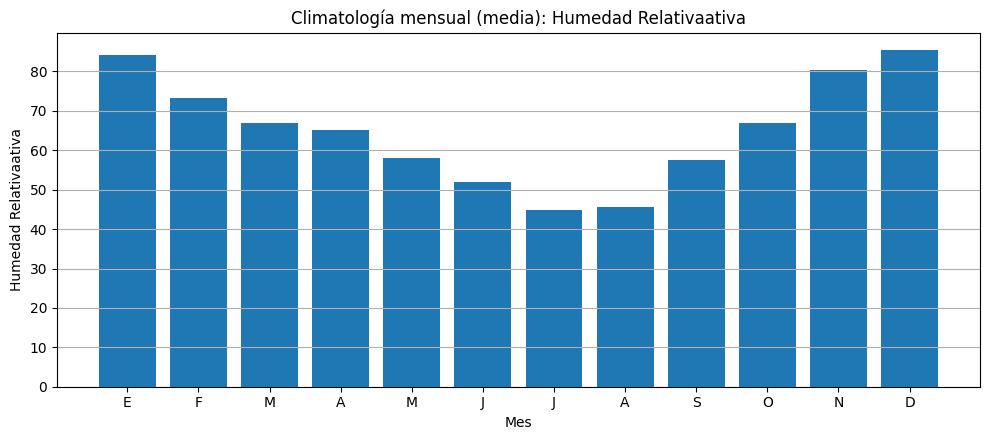

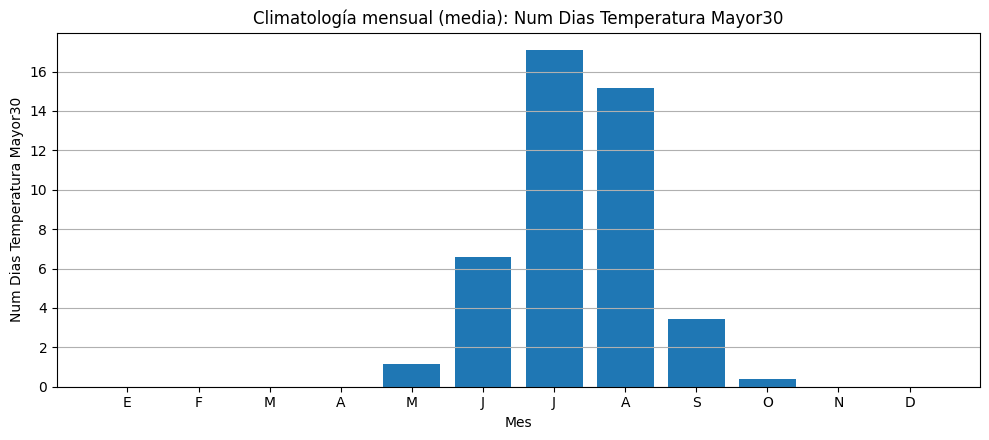

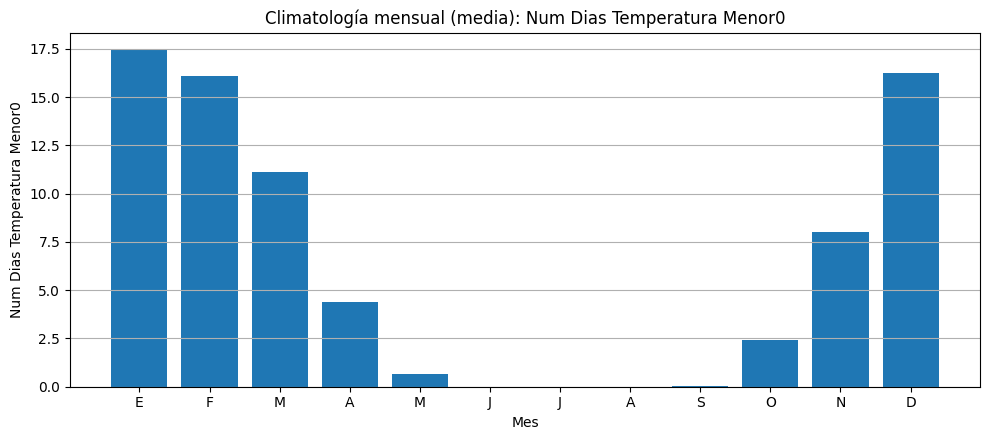

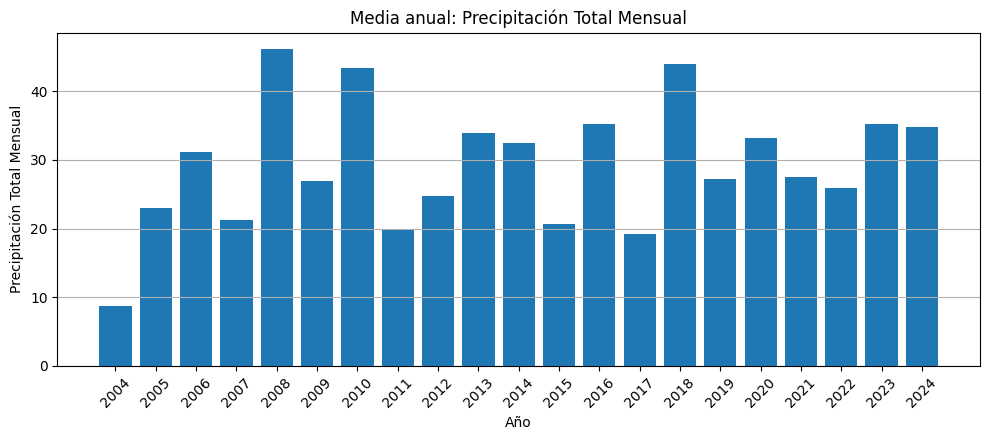

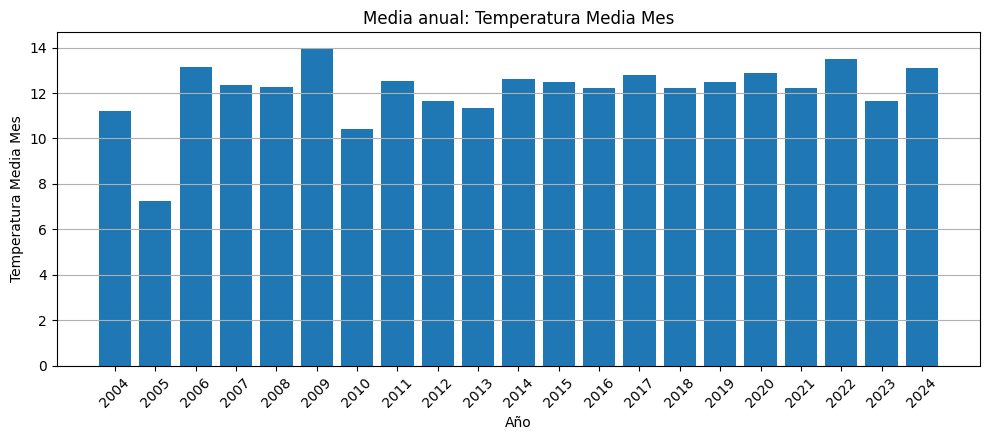

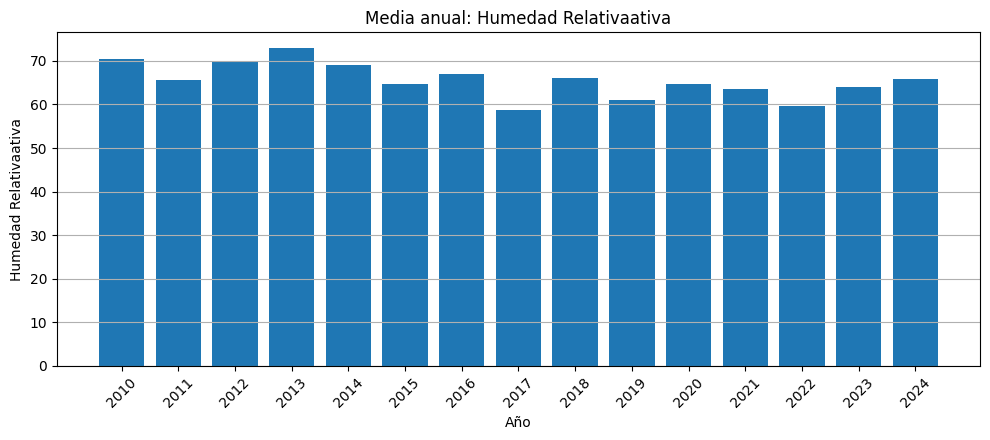

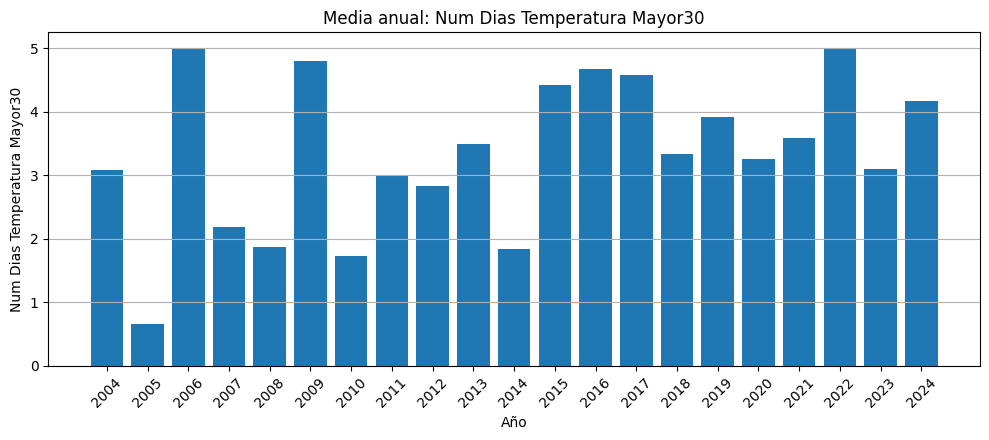

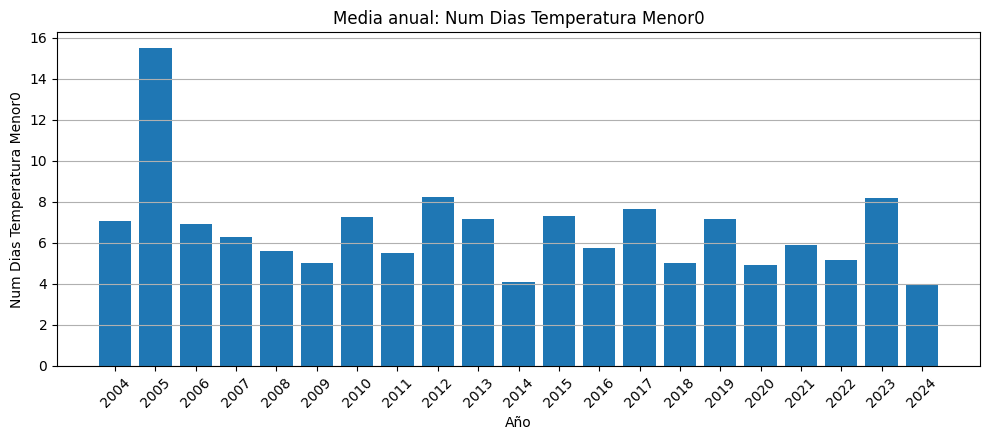

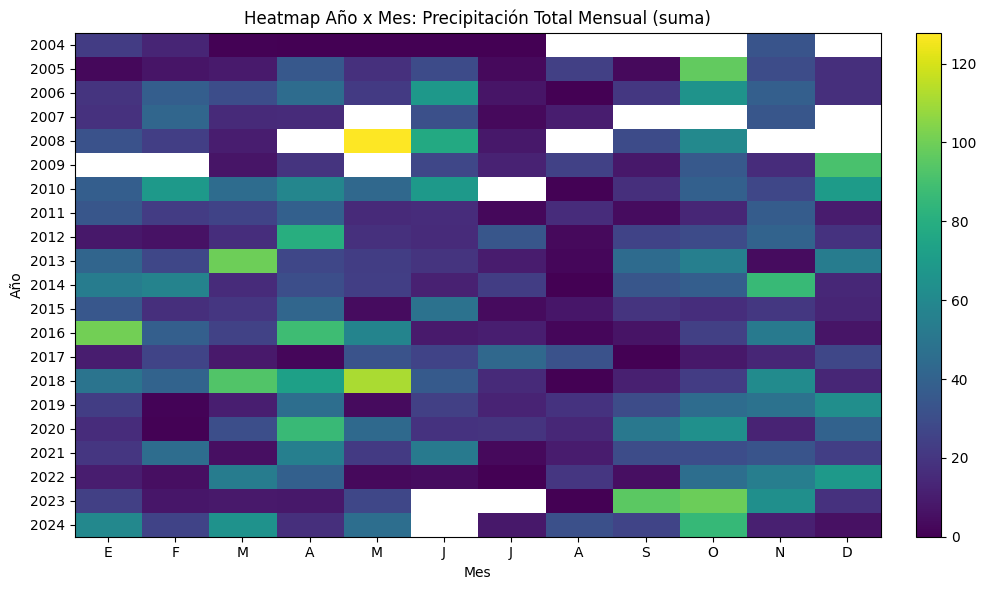

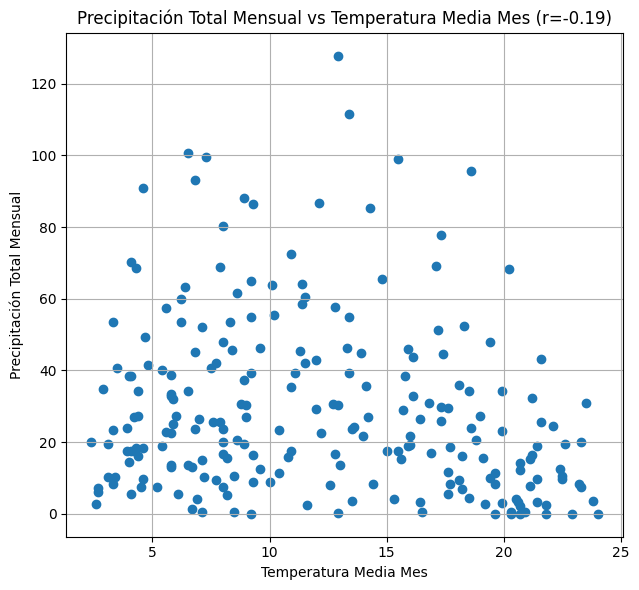

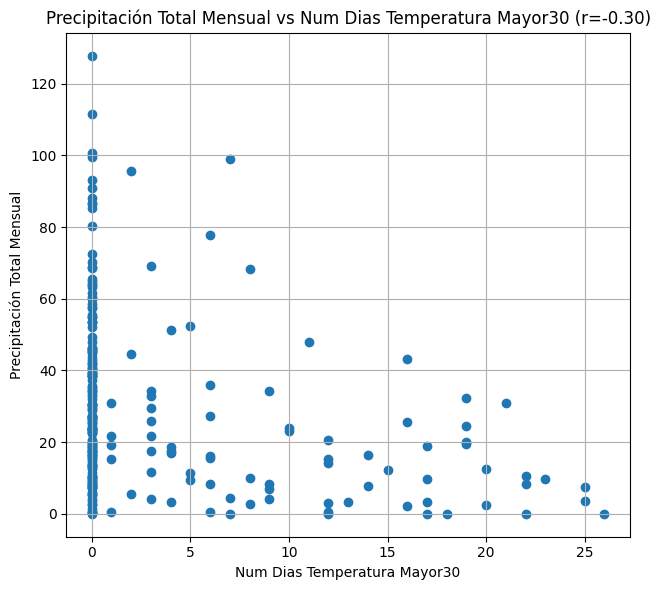

In [33]:
# ---------- LLAMADAS A LOS GRÁFICOS ----------

# Elige las variables climáticas que quieres ver
cols = [
    "precipitacion_total_mensual",
    "temp_media_mes",
    "humedad_relativa",
    "num_dias_temp_mayor30",
    "num_dias_temp_menor0",
]

# 1) Series temporales
for col in cols:
    plot_time_series(df, col)

# 2) Climatología mensual (media)
for col in cols:
    plot_monthly_climatology(df, col, agg="mean")

# 3) Agregado anual (media)
for col in cols:
    plot_annual_aggregate(df, col, agg="mean")

# 4) Heatmap año x mes para precipitación (usando suma mensual)
plot_year_month_heatmap(df, "precipitacion_total_mensual", agg="sum")

# 5) Alguna dispersión interesante, por ejemplo:
plot_scatter_with_corr(df, "temp_media_mes", "precipitacion_total_mensual")
plot_scatter_with_corr(df, "num_dias_temp_mayor30", "precipitacion_total_mensual")


In [31]:
def plot_annual_aggregate(df: pd.DataFrame, col: str, agg: str = "mean"):
    """Agregado anual para ver tendencias por año (media/mediana/suma)."""
    if "año" not in df.columns:
        raise ValueError("Falta columna 'año'.")
    temp = df[["año", col]].dropna()
    if temp.empty:
        return
    if agg == "sum":
        ann = temp.groupby("año")[col].sum()
        ttl = "Acumulado anual"
    elif agg == "median":
        ann = temp.groupby("año")[col].median()
        ttl = "Mediana anual"
    else:
        ann = temp.groupby("año")[col].mean()
        ttl = "Media anual"

    años = ann.index.astype(int)

    plt.figure(figsize=(10, 4.5))
    plt.bar(años, ann.values)
    plt.title(f"{ttl}: {prettify_label(col)}")
    plt.xlabel("Año")
    plt.ylabel(prettify_label(col))

    # 👉 Fuerza a que se vean TODOS los años en el eje X
    plt.xticks(años, años, rotation=45)

    plt.grid(True, axis="y")
    plt.tight_layout()
    plt.show()
